<center> <b>
    <font size = 8, color = '#30bf8b'>
Online Retail Sales Clustering

<b/><center/>

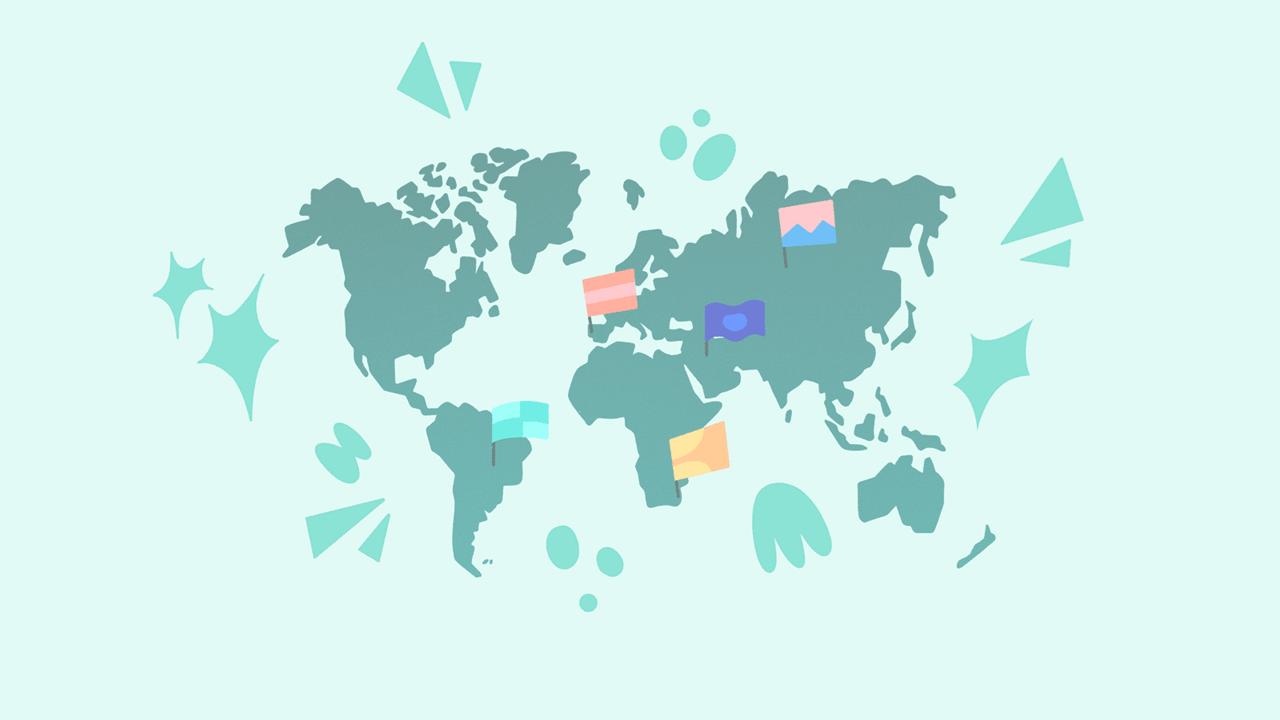

In [1]:
from IPython.display import display, Image

display(Image('OnlineRetailSalesClusteringCover.png'))

## Summary

- Ojective:
  
This project continues the work initiated in the <a href = 'https://github.com/domingosdeeulariadumba/OnlineRetailSalesAnalysis' target = '_blank' >
        Online Retail Sales Analysis.</a> While the previous project focused on examining transaction data from a U.K.-based online retail company to uncover insights into customer behavior based on purchasing patterns, this project shifts its focus to cluster analysis of the same dataset. Specifically, it aims to analyze and evaluate the average sales from the Top 5 countries, considering all relevant attributes.

## Dependencies

In [2]:
# Data manipulation
import os
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Clustering
from eval_models import optimal_nclusters
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score as ch_score

# Ignoring warnings
from warnings import filterwarnings as fw
fw('ignore')

## Exploratory Data Analysis

In [3]:
# Reading the dataset as a Pandas dataframe

dataset = os.path.abspath(os.path.join(os.getcwd(), '../OnlineRetailSalesAnalysis/OnlineRetailDataset.csv'))

df = pd.read_csv(dataset, encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Main info of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Dropping missing entries

df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [6]:
# Dropping transactions done on credit

df = df[~(df.InvoiceNo.str.contains('C'))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  float64
 7   Country      397924 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


In [7]:
# Lists of categorical and numeric attributes

cat_cols = list(df.dtypes[df.dtypes == object].index)
num_cols = list(df.dtypes[~(df.dtypes == object)].index)

In [8]:
# Statistical summary for categorical attributtes

df[cat_cols].describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,397924,397924,397924,397924,397924
unique,18536,3665,3877,17286,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,11/14/2011 15:27,United Kingdom
freq,542,2035,2028,542,354345


In [9]:
# Statistical summary for numeric attributtes

df[num_cols].describe().round(2)

,Quantity,UnitPrice,CustomerID
count,397924.00,397924.00,397924.00
mean,13.02,3.12,15294.32
std,180.42,22.10,1713.17
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


In [10]:
# Mean Unit Price and Quantity data by country

avg_data = df[['UnitPrice', 'Quantity', 'Country']].groupby('Country').mean().groupby('Country').mean().reset_index()
avg_data.head()

,Country,UnitPrice,Quantity
0,Australia,3.048523,71.062447
1,Austria,4.256030,12.263819
2,Bahrain,4.644118,15.294118
3,Belgium,3.630158,11.441162
4,Brazil,4.456250,11.125000


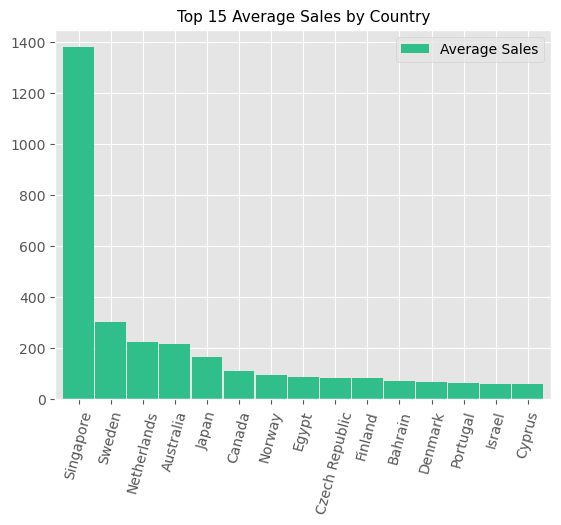

In [11]:
# Plotting average sales by Country

avg_data['Sales'] = avg_data.UnitPrice * avg_data.Quantity
avg_data.sort_values('Sales', inplace = True, ascending = False)
def_color = '#30bf8b'
avg_data.head(15).plot.bar(x = 'Country', y = 'Sales', 
                           color = def_color, width = .96, label = 'Average Sales')
plt.xlabel('')
plt.xticks(rotation = 75)
plt.title('Top 15 Average Sales by Country', 
         fontsize = 11)
plt.show()

In [12]:
# Filtering the top 5 countries in terms of average sales

top5_df = df[df.Country.isin(avg_data.head(5).Country)]
top5_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,12/1/2010 10:03,8.50,12431.0,Australia
198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,12/1/2010 10:03,4.95,12431.0,Australia
199,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,12/1/2010 10:03,1.25,12431.0,Australia
200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,12/1/2010 10:03,5.45,12431.0,Australia
201,536389,35004G,SET OF 3 GOLD FLYING DUCKS,4,12/1/2010 10:03,6.35,12431.0,Australia


## Preprocessing and Clustering

In [13]:
# Pipeline for DataFrame Transformation

pipeline = Pipeline(steps = [
    ('encoder', OneHotEncoder(drop = 'first', sparse = False)),
    ('rb_scaler', RobustScaler()),
    ('st_scaler', StandardScaler()),
    ('pca', PCA(2, random_state = 79))
])

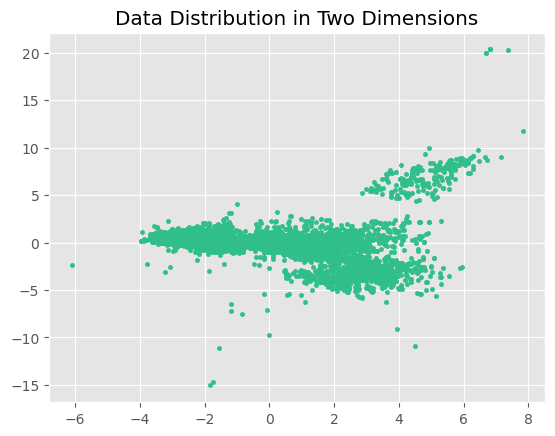

In [14]:
# Deimensionality reduction and data distribution

trf_data = pipeline.fit_transform(top5_df)
plt.scatter(trf_data.T[0], trf_data.T[1], 
            marker = '.', color = def_color)
plt.title('Data Distribution in Two Dimensions')
plt.show()

In [15]:
# Tecniques and palettes to be used

techniques = ['K-Mmeans', 'DBSCAN', 'HDBSCAN']
palette_ = ['#30bf8b', '#84421D', '#1F78B4', '#E31A1C']

- K-Means Clustering

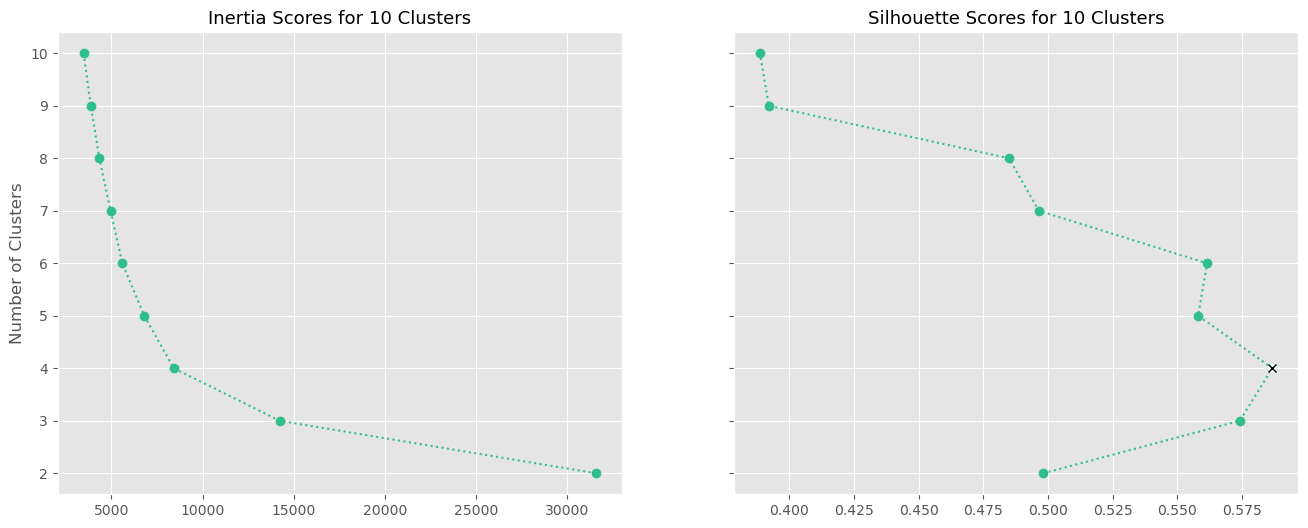

In [16]:
# Optimal number of clusters via elbow method and silhouette score

optimal_nclusters(trf_data, color_ = def_color, fontsize_ = 13, bold_ = False)

In [17]:
# Getting the optimal number of clusters

opt_n_clusters = optimal_nclusters(trf_data, plot_ = False)
opt_n_clusters

4

In [18]:
# DataFrames with labels and clusters center coordinates for K-Means

kmeans = KMeans(opt_n_clusters)
kmeans.fit(trf_data)
labels_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_

In [19]:
# DataFrame for storing DBSCAN clustering results

df_kmeans = pd.DataFrame(
    np.hstack((trf_data, labels_kmeans[:, np.newaxis])), 
    columns = ['val1', 'val2', 'group']
)
df_kmeans['group'] = df_kmeans.group.astype('int')
df_kmeans_centers = pd.DataFrame(centers, columns = ['x', 'y'])

In [20]:
# Cluster sizes using K-Means

df_kmeans.group.value_counts()

group
3    2138
2    1456
1     724
0     224
Name: count, dtype: int64

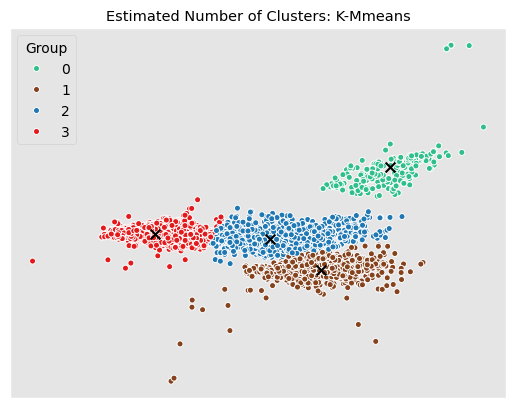

In [21]:
# Plotting

sns.scatterplot(
    data = df_kmeans, x = df_kmeans.columns[0], y = df_kmeans.columns[1], 
     hue = 'group', marker = '.', s = 75,
    palette = palette_
)
plt.legend(title = 'Group')
plt.scatter(df_kmeans_centers.x, df_kmeans_centers.y, 
            color = 'k', marker = 'x', s = 50
           )
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.title(f'Estimated Number of Clusters: {techniques[0]}', 
         fontsize = 10.5)
plt.show()

 - DBSCAN

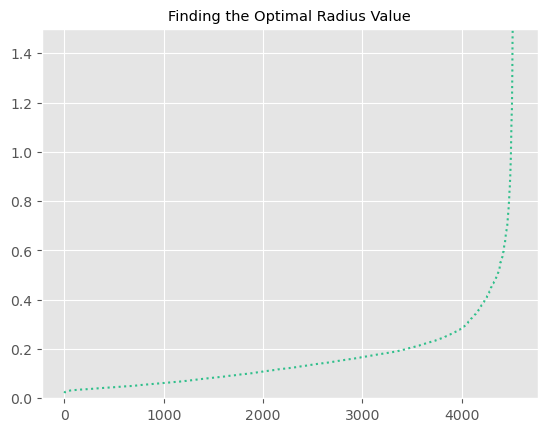

In [22]:
# Finding the optimal eps value

neighbors = NearestNeighbors(n_neighbors = 10).fit(trf_data)
average_distances, _ = neighbors.kneighbors(trf_data)
farthest_points = np.sort(average_distances[:, -1])

plt.plot(farthest_points, ':', 
         color = '#30bf8b')
plt.ylim(0, 1.5) # Axis limit adjusted for better visualize the elbow
plt.title('Finding the Optimal Radius Value', 
          fontsize = 10.5)
plt.show()

In [23]:
# DBSCAN parameters setting

min_samples_ = top5_df.shape[1] * 2
dbscan = DBSCAN(eps = .6, min_samples = min_samples_)
dbscan.fit(trf_data)
labels_dbscan = dbscan.labels_

In [24]:
# Dataframe for storing DBSCAN clustering results

df_dbscan = pd.DataFrame(
    np.hstack((trf_data, labels_dbscan[:, np.newaxis])), 
    columns = ['val1', 'val2', 'group']
)
df_dbscan['group'] = df_dbscan.group.map(
    lambda value: 'Outliers' if value == -1 else 
                                     int(value)
                                    )

In [25]:
# Group sizes after DBSCAnNclustering

df_dbscan.group.value_counts()

group
0           4254
1            206
Outliers      82
Name: count, dtype: int64

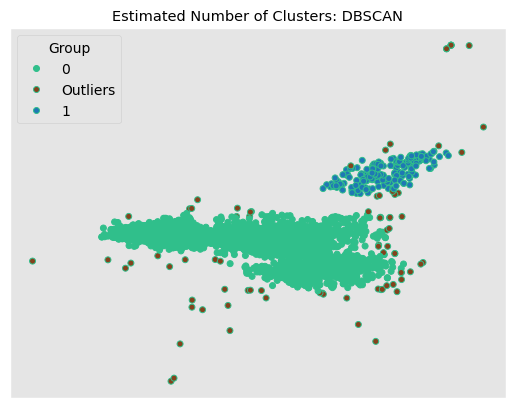

In [26]:
# Clustering results for DBSCAN

sns.scatterplot(
    df_dbscan, x = df_dbscan.columns[0], y = df_dbscan.columns[1],
                hue = 'group', marker = '.', s = 75,
    edgecolor = '#30bf8b', palette = palette_)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.legend(title = 'Group')
plt.title(f'Estimated Number of Clusters: {techniques[-2]}', 
          fontsize = 10.5)
plt.show()

- HDBSCAN

In [27]:
# HDBSCAN parameters setting

hdbscan = HDBSCAN(min_samples = min_samples_)
hdbscan.fit(trf_data)
labels_hdbscan = hdbscan.labels_

In [28]:
# DataFrame for HDBSCAN

df_hdbscan = pd.DataFrame(
    np.hstack((trf_data, labels_hdbscan[:, np.newaxis])), 
    columns = ['val1', 'val2', 'group']
)
df_hdbscan['group'] = df_hdbscan.group.map(
    lambda value: 'Outliers' if value == -1 else 
                                     int(value)
                                    )

In [29]:
# Checking group sizes

df_hdbscan.group.value_counts()

group
0           4300
1            216
Outliers      26
Name: count, dtype: int64

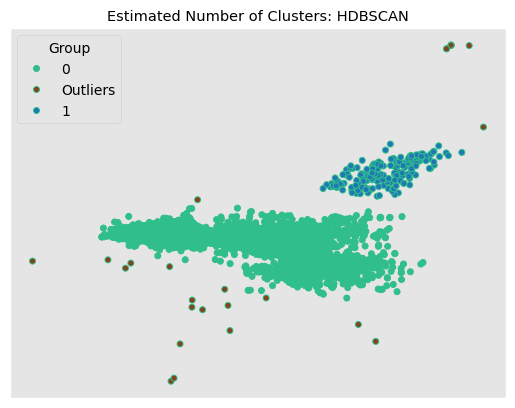

In [30]:
# Clustering results for HDBSCAN

sns.scatterplot(
    df_hdbscan, x = df_hdbscan.columns[0], y = df_hdbscan.columns[1],
                hue = 'group', marker = '.', s = 75,
    edgecolor = '#30bf8b', palette = palette_)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.legend(title = 'Group')
plt.title(f'Estimated Number of Clusters: {techniques[-1]}', 
          fontsize = 10.5)
plt.show()

## Performance Evaluation

In [31]:
# Below is presented a DataFrame displaying clustering evaluation metrics 

pd.DataFrame({
    'Silhouette Score': 
    [silhouette_score(trf_data, labels_kmeans),
     silhouette_score(trf_data, labels_dbscan),
     silhouette_score(trf_data, labels_hdbscan)], 
    
    'Calinski-Harabasz Score': 
    [ch_score(trf_data, labels_kmeans),
     ch_score(trf_data, labels_dbscan),
     ch_score(trf_data, labels_hdbscan)]}, 
             
             index = techniques).round(2).sort_values(
    'Silhouette Score', ascending = False) # Since the Silhouette Score is more robust, the data is ordered in terms of this index.

,Silhouette Score,Calinski-Harabasz Score
HDBSCAN,0.64,1003.10
K-Mmeans,0.59,8248.92
DBSCAN,0.58,990.94


<p>
    <strong> Source</strong>
    <br>
    UCI Machine Learning Repository.
    <a href = 'https://archive.ics.uci.edu/dataset/352/online+retail' target = '_blank' >
        Online Retail Dataset.</a>    
    <br><br> 
    <strong> Introductory Paper</strong><br>
    <a href = 'https://www.semanticscholar.org/paper/e43a5a90fa33d419df42e485099f8f08badf2149' target = '_blank'>
       Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. 
    </a>
    Daqing Chen, Sai Laing Sain, Kun Guo. 2012. n Journal of Database Marketing and Customer Strategy Management, Vol. No. 3.
     <br><br>
    <strong>Licence</strong><br>
    <a href = 'https://creativecommons.org/licenses/by/4.0/legalcode' target = '_blank'>
     Creative Commons Attribution 4.0 International.</a>
    <br><br>
     <strong> Cover</strong>
    <br>
Madalena Castro, in
<a href = 'https://blog.saleslayer.com/how-to-do-international-market-segmentation-in-a-marketplace' target = '_blank'>
     How to Do International Market Segmentation in a Marketplace</a>
     <br><br><br>
<em>Last accessed on December, 01 2024.</em>
<p/>